In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

data_seed: 123


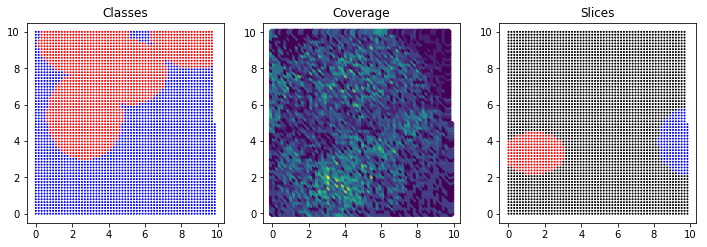

In [2]:
from torch.utils.data import DataLoader

from metal.utils import SlicingDataset
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset
from metal.utils import split_data

K = 2
M = 20
N = 4000
NUM_SLICES = 2
BATCHSIZE = 32
UNIPOLAR = True
# DATA_SEED = np.random.randint(1e6)
DATA_SEED = 123
print(f"data_seed: {DATA_SEED}")

Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, _ = generate_dataset(K, M, N, 
                                 Z_kwargs=Z_kwargs,
                                 unipolar=UNIPOLAR,
                                 slice_source="maxmin",
                                 seed=DATA_SEED)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

## LabelModel

In [3]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Ys[0] = Y_train_ps

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.692

In [4]:
import torch
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=BATCHSIZE,
    shuffle=True
)

dev_loader = DataLoader(SlicingDataset(Xs[1], Ls_tensors[1], Ys[1]))

test_loader = DataLoader(SlicingDataset(Xs[2], Ls_tensors[2], Ys[2]))

## SliceMaster

In [5]:
# Define custom metrics
from metal.metrics import accuracy_score
from metal.utils import convert_labels

def calc_heads_acc(model, dataloader):
    X, L, Y = dataloader.dataset.data
    L_probs, Y_off_probs, Y_on_probs = model.predict_all_proba(X)

    if model.indicator:
        L = L.clone()
        L[L == 2] = 1
    else:
        raise NotImplemented("Cannot evaluate L predictions if model.indicator=False")
    
    Y_off_preds = convert_labels(np.round(Y_off_probs[:, 0]), "onezero", "categorical")
    Y_on_preds = convert_labels(np.round(Y_on_probs[:, 0]), "onezero", "categorical")
    metrics = {}    
    
    metrics = {
        "L_acc": accuracy_score(L.flatten(), np.round(L_probs).flatten()),
        "Y_off_acc": accuracy_score(Y, Y_off_preds),
        "Y_on_acc": accuracy_score(Y, Y_on_preds),     
    }
    
    return metrics

def calc_slice_acc(model, dataloader):
    model.warn_once("Slice accuracies currently only work for valid set!")
    X, L, Y = dataloader.dataset.data
    Y_preds = model.predict(X)

    metrics = {}
    for s in range(1, NUM_SLICES + 1):
        inds = [i for i, e in enumerate(Zs[1]) if e == s]
        X_slice = X[inds]
        Y_slice = Y[inds]
        Y_preds_slice = Y_preds[inds]
        acc = model.score((X_slice, None, Y_slice), verbose=False)
        metrics[f"slice_{s}"] = acc
    return metrics

In [24]:
import os

# MODEL_SEED = np.random.randint(1e6)
MODEL_SEED = 123
print(f"model_seed: {MODEL_SEED}")

RUN_NAME = f"{DATA_SEED}_{MODEL_SEED}_SM"

em_config = {
    "layer_out_dims": [2, 5, 5, 2],
    "verbose": False,
    "seed": MODEL_SEED,
}

sm_config = {
    "L_weight": 0.1,
    "Y_off_weight": 0.1,
    "vanilla": False,
    "online_head": True,
    "indicator": True,
    "mask_abstains": False,
    "verbose": True,
}

train_kwargs = {
    "n_epochs": 30,
    "lr": 0.001,
    "l2": 0.0,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc], # calc_heads_acc],
#     "log_valid_metrics": ["L_acc", "Y_off_acc", "Y_on_acc"],
    "checkpoint": True,
#     "checkpoint_metric": "Y_on_acc",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/",
    "run_name": RUN_NAME,
}

model_seed: 123


In [25]:
from metal.end_model import EndModel
from metal.contrib.slicing.slice_model import SliceMaster
from metal.contrib.slicing.experiment_utils import eval_model

base_model = EndModel(**em_config)
model = SliceMaster(base_model, m=Ls[0].shape[1], **sm_config)
model.train_model(train_loader, valid_data=dev_loader, **train_kwargs)
# model.score(test_loader)
# calc_slice_accuracy(model, test_loader)
results = eval_model(model, (Xs[2], Ys[2], Zs[2]), verbose=False)

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=20, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=0.689] VALID:[slice_1=0.574, slice_2=0.405, accuracy=0.752]
Saving model at iteration 1 with best score 0.752
[2 epo]: TRAIN:[loss=0.682] VALID:[slice_1=0.574, slice_2=0.000, accuracy=0.699]
[3 epo]: TRAIN:[loss=0.674] VALID:[slice_1=0.574, slice_2=0.167, accuracy=0.696]
[4 epo]: TRAIN:[loss=0.663] VALID:[slice_1=0.574, slice_2=0.810, accuracy=0.782]
Saving model at iteration 4 with best score 0.782
[5

In [8]:
# """Are we recovering the Ls?"""

# L_probs = model.predict_L_proba(torch.Tensor(Xs[1]))
# if sm_config["indicator"]:
#     L_preds = np.round(L_probs)
#     L_preds[L_preds == 0] = 2

#     # 0 is negative, {1,2} are positive
#     L_gold = np.asarray(Ls[1].todense())
#     L_gold[L_gold != 0] = 1
#     L_gold[L_gold == 0] = 2

# print()
# for j in [0,1,2]:
#     score = accuracy_score(L_gold[:,j], L_preds[:,j], ignore_in_gold=[0])
#     print(f"LF_{j}: {score}")